Alunos:

Artur Henrique do Carmo Rosa - 222028738

Walisson

O objetivo deste caderno é estudar as classes, atributos, métodos e funções disponíveis para uso no pytorch, D2L, etc. Bem como avaliar o desempenho de diversos modelos de classificadores lineares.

In [119]:
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

O conjunto de dados que utilizaremos no trabalho já está definido pela classe MNIST.

In [120]:
class MNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)

@d2l.add_to_class(MNIST)  #@save
def get_dataloader(self, train:bool):
    if train == True:
        data = self.train
    else:
        data = self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

A classe MNIST é um dataset de imagens de números.

Parâmetros: `batch_size` significa tamanho do lote. O processamento de dados em lote poupa memória. `resize` redimensiona a largura e a altura respectivamente das imagens.

Atributos: `train` é uma matriz com 60000 exemplos de treinamento. `val` é uma matriz com 10000 exemplos de validação. Cada exemplo é uma imagem de 28x28 pixels.

O método `get_dataloader` retorna um objeto para que o pytorch possa carregar os dados.

Parâmetros: `train` se verdadeiro, então utiliza o conjunto de treinamento, senão o conjunto de validação.

Implementamos uma função para visualizar os exemplos do conjunto de treinamento. Foram mostradas as primeiras 20 imagens:

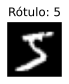

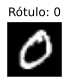

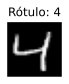

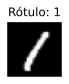

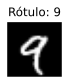

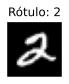

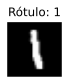

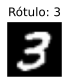

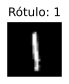

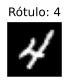

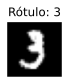

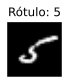

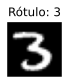

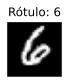

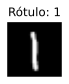

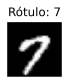

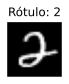

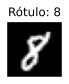

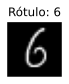

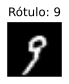

In [121]:
def view_MNIST(i:int):
    mnist_data_module = MNIST()
    image_tensor, label = mnist_data_module.train[i] 
    image_np = image_tensor.squeeze().numpy()
    plt.figure(figsize=(1, 1)) 
    plt.imshow(image_np, cmap='gray') 
    plt.title(f"Rótulo: {label}")
    plt.axis('off') 
    plt.show()

for i in range(0, 20):
    view_MNIST(i)

Vamos criar nossa primeira rede neural e tentar, aos poucos, ir aprimorando ela a cada versão. Começando com um perceptron com uma camada escondida, função de ativação sigmoide e otimização por descida de gradiente:

In [122]:
class MLP_2a(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens=128, lr=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.Sigmoid(),
            nn.LazyLinear(num_outputs)
        )

A otimização por descida de gradiente já é configurada por padrão no módulo d2l.

A função sigmoidal combinada com a otmização por descida de gradiente pode causar o problema de retropropagação evanescente.

Parâmetros: `num_outputs` é o número de classes do conjunto de dados que serão classificadas pela rede neural. `num_hiddens` é o número de neurônios da camada oculta. Toda camada que não é de entrada e nem de saída é chamada de camada oculta, porque elas estão "escondidas" no interior da rede. `lr` "learning rate" é a taxa ou velocidade de aprendizado do modelo.

A seguinte função calcula a acurácia do modelo:


In [123]:
def evaluate_accuracy(model, data_iter):
	model.eval()
	metric = d2l.Accumulator(2)
	with torch.no_grad():		
		for X, y in data_iter:
			metric.add(d2l.accuracy(model(X), y), y.numel())
	model.train()
	return metric[0] / metric[1]

Treinamento:


Final validation accuracy:  0.9267


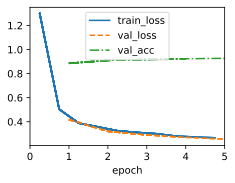

In [124]:
data = MNIST()
model = MLP_2a()
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))

Gostaríamos de observar alguns dos exemplos mal classificados.

Total de exemplos mal classificados encontrados: 733


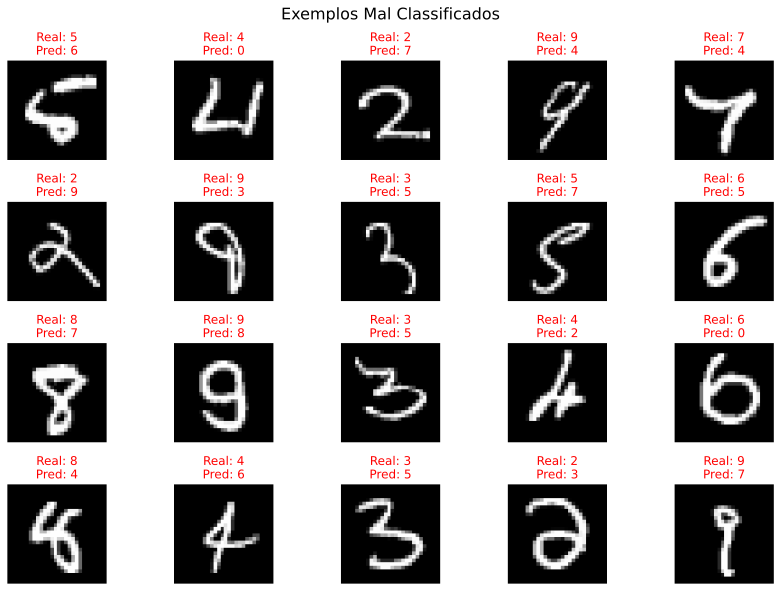

In [125]:
def get_mnist_text_labels(labels):
    """Retorna os nomes de classes textuais para os rótulos numéricos do MNIST."""
    return [str(int(i)) for i in labels]

def view_fail():
    # Coletar os exemplos mal classificados
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    # Colocar o modelo em modo de avaliação (desativa dropout, etc.)
    model.eval()

    # Desativar o cálculo de gradientes para economizar memória e acelerar o processo
    with torch.no_grad():
        
        # Itera sobre o DataLoader de validação
        for X, y in data.val_dataloader():
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            # Identifica os exemplos mal classificados no minibatch atual
            wrong_indices = (preds != y).nonzero(as_tuple=True)[0]

            if len(wrong_indices) > 0:
                # Coleta as imagens, rótulos verdadeiros e preditos dos erros
                misclassified_images.extend(X[wrong_indices].cpu())
                true_labels.extend(y[wrong_indices].cpu())
                predicted_labels.extend(preds[wrong_indices].cpu())

    # Visualizar os exemplos mal classificados
    print(f"Total de exemplos mal classificados encontrados: {len(misclassified_images)}")

    # Limita o número de exemplos a serem mostrados para evitar gráficos muito grandes
    num_to_display = min(len(misclassified_images), 20)
    if num_to_display > 0:
        fig, axes = plt.subplots(int(np.ceil(num_to_display / 5)), 5, figsize=(12, 2 * int(np.ceil(num_to_display / 5))))
        axes = axes.flatten()

        for i in range(num_to_display):
            img_tensor = misclassified_images[i]
            true_lbl = true_labels[i]
            pred_lbl = predicted_labels[i]

            img_np = img_tensor.squeeze().numpy()

            axes[i].imshow(img_np, cmap='gray')
            axes[i].set_title(f"Real: {get_mnist_text_labels([true_lbl])[0]}\nPred: {get_mnist_text_labels([pred_lbl])[0]}",
                            color='red')
            axes[i].axis('off')

        # Remove subplots vazios se num_to_display não preencher completamente a grade
        for j in range(num_to_display, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.suptitle("Exemplos Mal Classificados", y=1.02, fontsize=16)
        plt.show()

    else:
        print("Nenhum erro de classificação encontrado no conjunto de validação. O modelo está perfeito, ou o conjunto é muito pequeno!")

view_fail()

A matriz de confusão é uma tabela que resume o desempenho de um algoritmo de classificação. Ela mostra, para cada classe real, quantas amostras foram corretamente classificadas e quantas foram incorretamente classificadas em outras classes.

As linhas da matriz representam as classes reais das amostras. As colunas representam as classes preditas pelo modelo. Logo, os números da diagnoal principal indicam a quantidade de classificações corretas para cada classe. Enquanto que os números fora da diagnonal principal indicam a quantidade de classificações incorretas do modelo.

Implementamos a seguinte função para a matriz de confusão:

In [126]:
def matriz_confusao():
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for X, y in data.val_dataloader():
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    cm_mnist = confusion_matrix(all_labels, all_preds)
    print("\nMatriz de Confusão:\n", cm_mnist)

matriz_confusao()


Matriz de Confusão:
 [[ 964    0    3    2    0    4    5    1    1    0]
 [   0 1105    2    2    1    1    4    2   18    0]
 [  12    4  926   12   12    1   12   11   39    3]
 [   2    1   21  922    0   23    2   15   21    3]
 [   2    2    7    1  924    1   12    2    7   24]
 [  11    2    4   41    6  771   13    7   30    7]
 [  15    3    5    1    9   12  907    3    3    0]
 [   4    9   27    4    6    0    0  959    2   17]
 [   8    3    6   14    7   21    9    9  896    1]
 [  12    7    1   11   41    7    1   27    9  893]]


(análise de desempenho do modelo)

Repetindo o modelo, mas agora substituindo pelo Otimizador Adam. Esse tipo de otimização geralmente usa um lr menor:


In [127]:
class MLP_2b(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens=128, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.Sigmoid(),
            nn.LazyLinear(num_outputs)
        )
    def configure_optimizers(self):
            return torch.optim.Adam(self.parameters(), lr=self.lr)

Treinamento:

Final validation accuracy:  0.9631
Total de exemplos mal classificados encontrados: 369


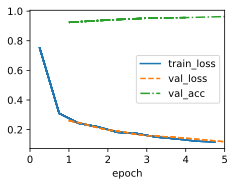

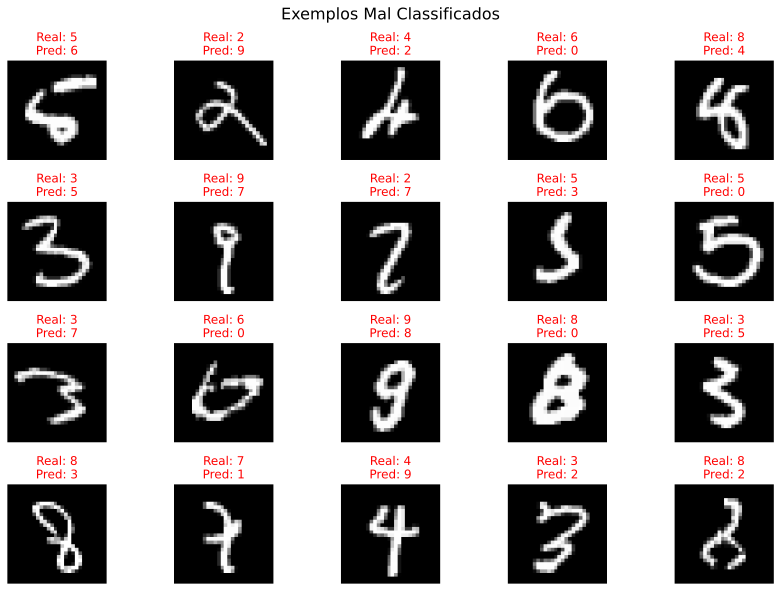


Matriz de Confusão:
 [[ 964    0    2    1    0    3    8    1    1    0]
 [   0 1119    2    1    0    1    3    2    7    0]
 [   6    2  985    4    7    1    7    8   10    2]
 [   2    1    5  968    0   11    0   10    9    4]
 [   1    0    4    0  947    0    5    3    2   20]
 [   7    2    0   12    2  844   10    2    7    6]
 [   6    3    2    1    6    4  931    0    5    0]
 [   1    9   14    4    2    1    0  981    0   16]
 [   6    3    3    8    6    5    6    6  927    4]
 [   2    6    0    6   16    3    1    7    3  965]]


In [128]:
data = MNIST()
model = MLP_2b()
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))
view_fail()
matriz_confusao()

(análise de desempenho do modelo)

Substituímos a função de ativação sigmoidal para a relu:

In [129]:
class MLP_2c(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens=128, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LazyLinear(num_outputs)
        )
    def configure_optimizers(self):
            return torch.optim.Adam(self.parameters(), lr=self.lr)

Treinamento:

Final validation accuracy:  0.9754
Total de exemplos mal classificados encontrados: 246


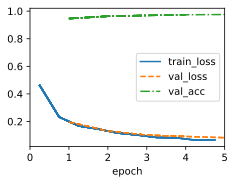

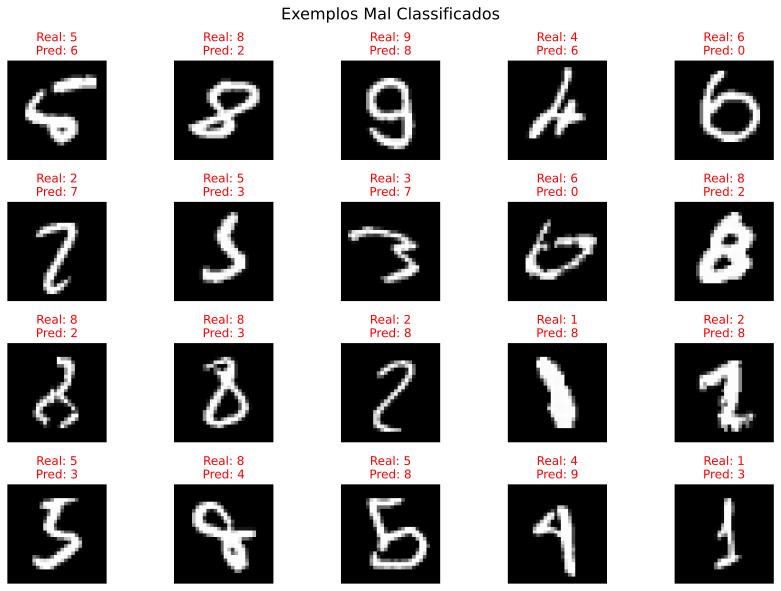


Matriz de Confusão:
 [[ 970    0    0    1    1    0    2    1    2    3]
 [   0 1117    3    3    0    1    3    1    7    0]
 [   5    1 1003    3    2    0    4    3   11    0]
 [   0    0    3  995    0    2    0    4    5    1]
 [   0    0    4    0  960    2    6    3    0    7]
 [   2    0    1   10    1  866    5    1    4    2]
 [   4    3    2    1    1    4  941    0    2    0]
 [   2    3   11    2    0    0    0 1004    0    6]
 [   7    0    5   11    5    5    4    4  930    3]
 [   1    3    0   10   15    2    1    4    5  968]]


In [130]:
data = MNIST()
model = MLP_2c()
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))
view_fail()
matriz_confusao()

(análise do modelo)

Vamos testar o que acontece se expandirmos nossa rede neural. Primeiramente, vamos duplicar o número de neurônios da camada oculta:

In [131]:
class MLP_2d_v1(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens=256, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LazyLinear(num_outputs)
        )
    def configure_optimizers(self):
            return torch.optim.Adam(self.parameters(), lr=self.lr)

Treinamento:

Final validation accuracy:  0.979
Total de exemplos mal classificados encontrados: 210


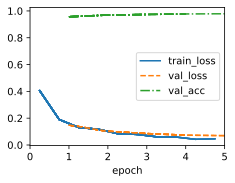

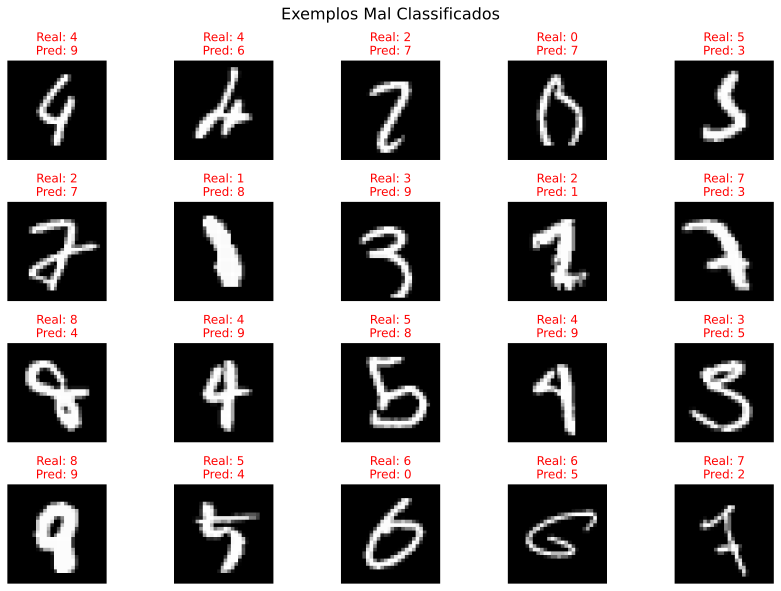


Matriz de Confusão:
 [[ 960    1    3    1    2    1    4    2    3    3]
 [   0 1128    2    1    0    0    2    0    2    0]
 [   2    6 1000    2    5    0    3    7    7    0]
 [   0    0    3  996    0    2    0    2    3    4]
 [   0    0    0    0  963    0    9    2    1    7]
 [   2    1    0   10    1  868    4    0    4    2]
 [   2    3    0    1    4    2  943    0    3    0]
 [   0    8    5    4    0    0    0 1001    2    8]
 [   1    0    1    8    5    2    2    2  951    2]
 [   0    5    0    8    6    4    1    1    4  980]]


In [132]:
data = MNIST()
model = MLP_2d_v1()
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))
view_fail()
matriz_confusao()

(análise de desempenho)

Expandindo mais ainda, agora vamos duplicar o número de camadas escondidas. Geralmente, as camadas ocultas mais próximas da entrada devem possuir mais neurônios, para capturar uma ampla gama de características. Enquanto que as camadas subsequentes, por terem menos neurônios, podem aprender representações mais compactas e de nível superior. Assim, segue a rede neural implementada:

In [133]:
class MLP_2d_v2(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens_1=256, num_hiddens_2=128, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens_1),
            nn.ReLU(),
            nn.LazyLinear(num_hiddens_2),
            nn.ReLU(),
            nn.LazyLinear(num_outputs)
        )
    def configure_optimizers(self):
            return torch.optim.Adam(self.parameters(), lr=self.lr)

Treinamento:

Final validation accuracy:  0.9774
Total de exemplos mal classificados encontrados: 226


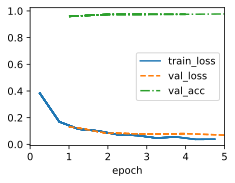

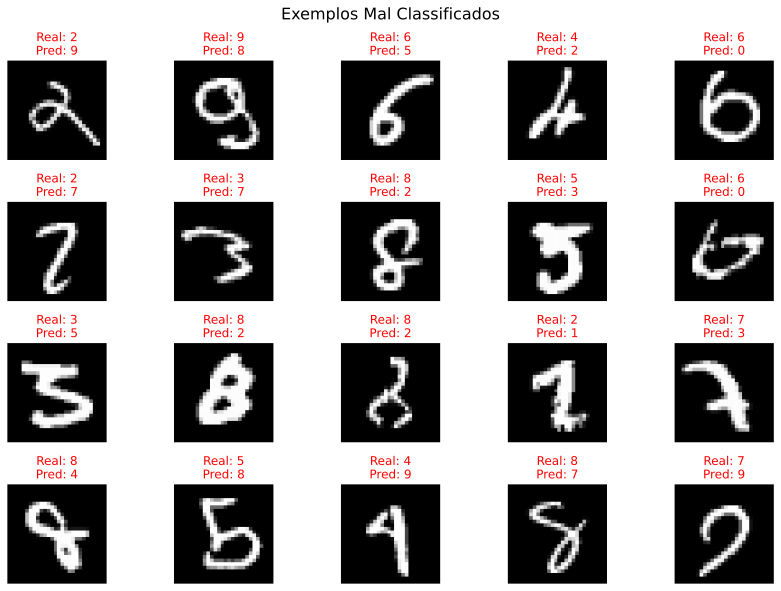


Matriz de Confusão:
 [[ 972    0    1    1    1    0    1    0    3    1]
 [   0 1128    3    1    0    1    2    0    0    0]
 [   2    2 1009    5    8    0    1    2    2    1]
 [   0    0    5  992    0    1    0    4    1    7]
 [   0    0    1    0  971    0    1    2    0    7]
 [   2    0    0   20    1  857    1    1    4    6]
 [   5    2    3    2    9    8  927    0    2    0]
 [   1    3    8    1    0    0    0 1006    1    8]
 [   2    2   11    7    5    3    4    5  930    5]
 [   2    3    0    7   12    0    0    2    1  982]]


In [134]:
data = MNIST()
model = MLP_2d_v2()
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))
view_fail()
matriz_confusao()

(análise do modelo)

(conclusões finais)